In [1]:
from torch_geometric.datasets import Entities
import os.path as osp
import networkx as nx
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import torch_geometric as pyg

import numpy as np

import LPGNN

device = 'cpu'

In [2]:
import importlib
importlib.reload(module=LPGNN)

<module 'LPGNN' from '/home/mf/Documents/IB/Tesis/Maestria/LPGNN/LPGNN/__init__.py'>

In [6]:
# PS Network

G_nx, G = LPGNN.network_generator.generatePSNetwork_nx(N=600, avg_k=8, gamma=2.5, Temp=0.0, seed=100)
G_nx.graph['size'] = 60
data = pyg.utils.from_networkx(G_nx)

In [70]:
# Generate Barabasi-Albert graph

# G_nx = nx.barabasi_albert_graph(200, m=4)

# Generate Ring of Cliques

# num_cliques = 18
# clique_size = 8
# r = 0.1
# G_nx = nx.ring_of_cliques(num_cliques, clique_size)
# G_nx.graph['pos'] = {}
# for node in G_nx.nodes:
#     c = node // clique_size
#     theta_c = 2*np.pi/num_cliques*c
#     x_c = np.cos(theta_c)
#     y_c = np.sin(theta_c)
#     i = node % clique_size
#     theta_i = 2*np.pi/clique_size*i + np.pi/4*c
#     x_i = r*np.cos(theta_i)
#     y_i = r*np.sin(theta_i)
#     G_nx.graph['pos'][node] = np.array([x_c+x_i, y_c+y_i])
# fig = plt.figure(figsize=(12, 12))
# #nx.draw(G_nx, pos=G_nx.graph['pos'], with_labels=False)

In [189]:
# Set data.x to be the node positions returned by LaBNE, as a starting point for embedding
# Also include centrality measures

labne = LPGNN.network_generator.generateLaBNE(graph=G)
#data.x = torch.Tensor( np.transpose([labne.vs['x'], labne.vs['y']]) )
data.x = torch.Tensor( np.transpose([labne.vs['r'], labne.vs['theta'],
                                     list(nx.degree_centrality(G_nx).values()),
                                     list(nx.closeness_centrality(G_nx).values())]) )

# Split data
train_data, val_data, test_data = LPGNN.DataSetup.train_test_split(data, test_ratio=0.05, val_ratio=0.05, neg_samples=True)

In [194]:
# GraphSAGE model + training
model = pyg.nn.GraphSAGE(in_channels=data.num_features, hidden_channels=32, out_channels=2, num_layers=3, dropout=0.1, root_weight=True, aggr="mean")
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
_ = LPGNN.GraphNeuralNet.train_model(model, optimizer, train_data, test_data, val_data, epochs=10)

# Evaluate model
model.eval()
torch.no_grad()
z = model.forward(data.x, data.edge_index)
# Save z as embedding
embedding = {node:np.array([value[0], value[1]]) for node, value in enumerate(z.detach().numpy())}

 Epoch | Train loss | Val loss
-------|------------|-----------
----0001----|---2.668---|---0.738---
----0002----|---6.849---|---0.821---
----0003----|---1.136---|---0.793---
----0004----|---0.774---|---0.789---
----0005----|---0.756---|---0.785---
----0006----|---0.736---|---0.783---
----0007----|---0.725---|---0.781---
----0008----|---0.718---|---0.780---
----0009----|---0.721---|---0.778---
----0010----|---0.716---|---0.777---



(<Figure size 864x720 with 1 Axes>, <AxesSubplot:>)

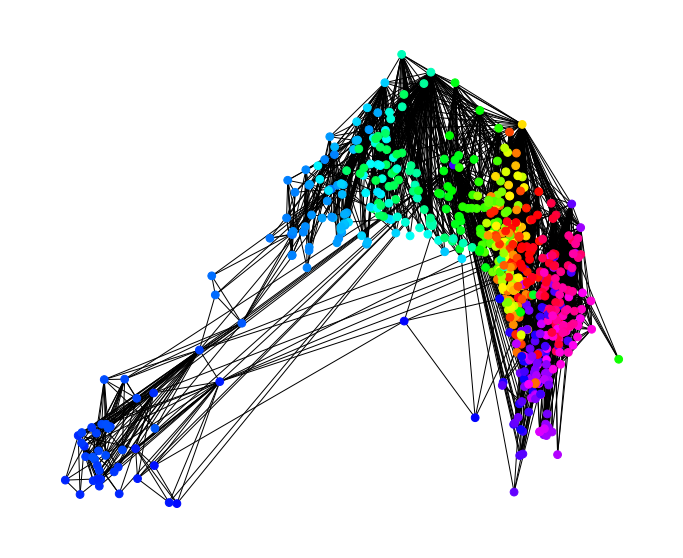

In [195]:
LPGNN.visualization.gnn_attr_passing.draw_embedding(G_nx, embedding=embedding)

In [196]:
#G_nx.graph['pos'] = nx.spring_layout(G_nx)

xyG = np.array(list(G_nx.graph['pos']))
xyz = np.array(list(z.detach().numpy()[:,0:2]))

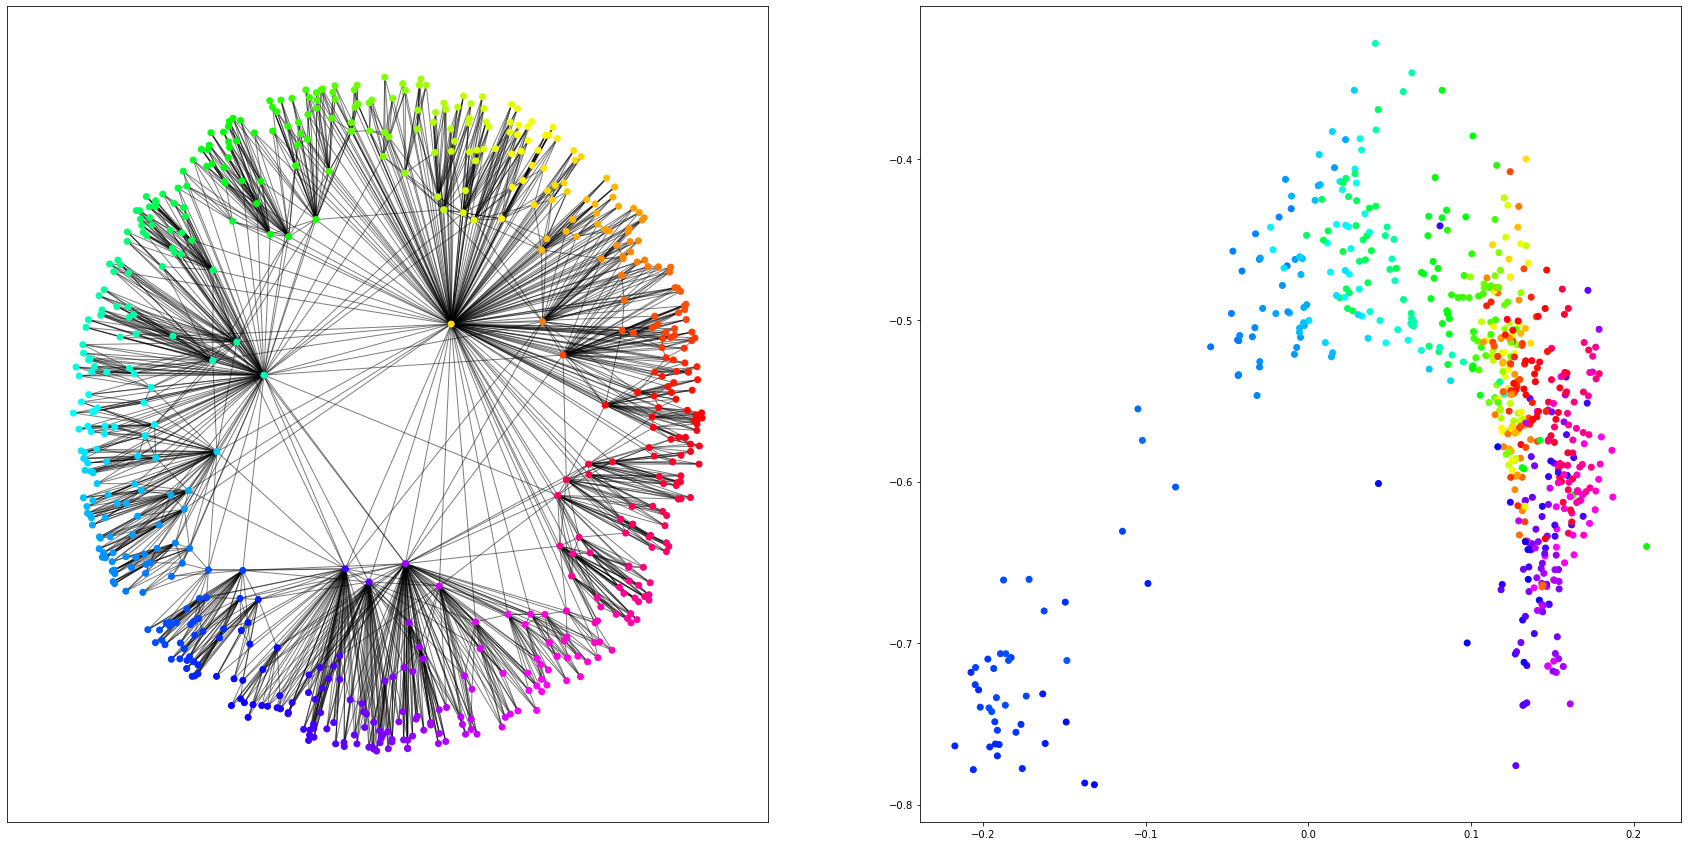

In [197]:
fig, axs = plt.subplots(1, 2, figsize=(30, 15))

nx.draw_networkx_edges(G_nx, G_nx.graph['pos'], alpha=0.5, ax=axs[0])
axs[0].scatter(xyG[:,0], xyG[:,1], c=G_nx.graph['color'])
axs[1].scatter(xyz[:,0], xyz[:,1], c=G_nx.graph['color'])

In [181]:
def pointsToDistances(xy):
    p = []
    for i in range(xy.shape[0]):
        for j in range(i+1, xy.shape[0]):
            p.append([i, j, np.linalg.norm(xy[i]-xy[j])])
    return p

In [198]:
scores = pointsToDistances(z.detach().numpy())
# Sort scores by distance
scores = sorted(scores, key=lambda x: x[2])

In [183]:
R, P, preds = LPGNN.LinkPrediction.precision_recall(test_data=test_data, predictions=scores)

In [184]:
PR_labne = LPGNN.GraphNeuralNet.LaBNE(PS=G, test=test_data)

/home/mf/Documents/IB/Tesis/Maestria/LPGNN/LPGNN/network_analysis.py:151: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  link_scores = np.array(link_scores)


(0.0, 0.1)

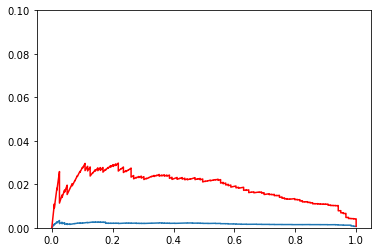

In [185]:
plt.plot(R, P)
plt.plot(PR_labne['recall'], PR_labne['precision'], c='red')
plt.ylim(0, 0.1)